# APS Lab 2: Finding Position with Linear Least Squares

### EE16A: Designing Information Devices and Systems I, Fall 2018

**Name 1:** 

**Login:** ee16a-

**Name 2:**

**Login:** ee16a-

#### [Introduction](#w3)
#### [Task 0: Imports](#task0)
#### [Multilateration: Finding linear relationships of positions given time differences](#q31)
#### [Task 1: Constructing the System of Equations](#task1)
#### [Task 2: Using Least Squares](#task2)
#### [Task 3a: Simulation Testing](#task3a)
#### [Task 3b: Real Life Positioning](#task3b)
#### [Task 3c: Getting your own recording](#task3c)

<a id='w3'></a>
## Introduction

If you have not completed APS 1 yet, do that one first, or this lab will not make any sense. You can finish APS 2 during buffer week.

In the last lab we introduced the signal processing part for our lab and obtained the TDOA's (Time Difference Of Arrivals) of different beacon signals. This week we are going to explore methods that help us determine the final position.

<a id='task0'></a>
# <span style="color:blue">Task 0: Imports</span>

In [1]:
%pylab inline
from __future__ import division
import random
import math
from IPython import display
import numpy as np

# Importing helper functions
%run support_code/virtual.py
%run support_code/signals.py
%run support_code/demod.py
v_air = 340.29
sampling_freq = 44100

def cross_correlation(signal1, signal2):
    """Compute the cross_correlation of two given periodic signals    
    """
    return np.fft.ifft(np.fft.fft(signal1) * np.fft.fft(signal2).conj()).real

def average_sigs(cross_correlations):
    """ Average multiple periods of cross-correlations of the received signal with a beacon """
    
    Lperiod = len(beacon[0])
    Ncycle = len(cross_correlations[0]) // Lperiod
    avg_sigs = []
    for c in cross_correlations:
        reshaped = c.reshape((Ncycle, Lperiod))
        averaged = np.mean(np.abs(reshaped), 0)
        avg_sigs.append(averaged)
        
    return avg_sigs


def signal_generator(x, y, noise=0):
    raw_signal = add_random_noise(simulate_by_location(x, y), noise)
    return demodulate_signal(raw_signal)


def identify_peak(signal):
    """Returns the index of the peak of the given signal."""
    peak_index = np.argmax(signal)
    return peak_index       


def arrival_time(beacon, signal):
    arrival_time = [None]*len(beacon);                             
    for i in range(len(beacon)): 
        sent_temp = beacon[i][:1000]                               
        ccorr_temp = cross_correlation(sent_temp,signal);
        arrival_time[i] = identify_peak(ccorr_temp);
    return arrival_time


def separate_signal(raw_signal):
    """Separate the beacons by computing the cross correlation of the raw signal 
    with the known beacon signals."""
    
    Lperiod = len(beacon[0])
    Ncycle = len(raw_signal) // Lperiod
    for ib, b in enumerate(beacon):
        c = cross_correlation(raw_signal[0:Lperiod],b)
        # Iterate through cycles
        for i in range(1,Ncycle):
            c = np.hstack([c, cross_correlation(raw_signal[i*Lperiod:(i+1)*Lperiod], b)])
        if (ib==0): cs = c
        else:       cs = np.vstack([cs, c])
    return cs


def identify_offsets(averaged):
    """ Identify peaks in samples.
    The peaks of the signals are shifted to the center."""
    
    # Reshaping (shifting) the input so that all of our peaks are centered about the peak of beacon0
    peak = identify_peak(averaged[0])
    shifted = [np.roll(avg, len(averaged[0]) // 2 - peak) for avg in averaged]
    
    peaks = [identify_peak(shifted[i]) for i in range(len(shifted))]
    peak_offsets = peaks - peaks[0]

    return peak_offsets


def offsets_to_tdoas(offsets, sampling_freq):
    """ Convert a list of offsets to a list of TDOA's """
    TDOA = list(np.array(offsets) / sampling_freq)
    return TDOA


def signal_to_offsets(raw_signal):
    """ Compute a list of offsets from the microphone to each speaker. """
    
    separated = separate_signal(raw_signal)
    averaged = average_sigs(separated)
    offsets = identify_offsets(averaged)
    
    return offsets


def signal_to_distances(raw_signal, t0):
    """ Returns a list of distancs from the microphone to each speaker. """
    
    offsets = signal_to_offsets(raw_signal)
    tdoas = offsets_to_tdoas(offsets, sampling_freq)
    all_dists = list(v_air*(t0 + np.array(tdoas)))
    
    return all_dists


def draw_hyperbola(p1, p2, d):
    """ hyperbola drawing function """
    
    p1=np.matrix(p1)
    p2=np.matrix(p2)
    pc=0.5*(p1+p2)
    p21=p2-p1
    d21=np.linalg.norm(p21)   
    th=np.array(np.matrix(list(range(-49,50)))*pi/100) #radian sweep list
    a=d/2
    b=((d21/2)**2-(a)**2)**0.5
    x=a/np.cos(th)
    y=b*np.tan(th) #hyperbola can be represented as (d*sec(th),d*tan(th))
    p=np.vstack((x,y))
    m=np.matrix([[p21[0,0]/d21, -p21[0,1]/d21],[p21[0,1]/d21, p21[0,0]/d21]]) #rotation matrix
    vc=np.vstack((pc[0,0]*np.ones(99),pc[0,1]*np.ones(99))) #offset
    return np.transpose(m*p+vc)


def get_signal_from_wav(wavFileName):
    """Get the signal from a pre-recorded wav file"""
    return mic.new_data_wav(wavFileName)


Populating the interactive namespace from numpy and matplotlib


### <a id='q31'></a>
# Multilateration: Finding linear relationships of positions given time differences.

Multilateration is a technique sometimes used in positioning systems to precisely locate a receiver by measuring the time difference of arrivals (TDOAs) from several synchronized *Beacons* at one receiver location.

Suppose we have $n$ beacons $B_0$, $B_1$, ... $B_{n - 1}$, so the position of a beacon $B_m$ in the 2-D plane will be $B_m = (x_m, y_m)$. These positions are known. We also have a receiver $R$ with unknown position $(x, y)$ in the same plane. Let $R_m$ denote the distance of $B_m$ to $R$, $R_m = \sqrt{(x - x_m)^2 + (y - y_m)^2}$. 

For simplification, in this lab we set the first beacon $B_0$ at position (0, 0), as a reference. We also let $\tau_0$, $\tau_1$ ... $\tau_{n - 1}$ denote the TDOA's. Since we are referencing the first beacon, $\tau_0$ is zero.

Recall from last week that we find the distances from speakers to the microphone with the arrival time of the first beacon $t_0$. However in a real application like GPS finding $t_0$ is impossible. Thus we are unable to get the exact distances from the speakers to the microphone. Instead of obtaining circles as we got last week, we are only able to get hyperbolic solutions, which is explained below.

**Setting up n-1 hyperbolic equations:** Luckily we can still find the relationship of position $R = (x, y)$ and $B_m = (x_m, y_m)$ with some calculations. Let $v_s$ be the speed of sound and $R_0$ be the distance between $R$ and Beacon $B_0$, which we have positioned at the origin. We can setup our initial equation using the fact distance is the speed of sound multiplied by the time of travel:

$$R_m - R_0 = v_s \tau_m$$
$$\text{multiply this by } R_m + R_0$$

---

$$(R_m - R_0)(R_m + R_0) = v_s \tau_m (R_m + R_0)$$
$$\text{Distribute left side}$$

---

$$R_m^2-R_0^2 = v_s \tau_m (R_m + R_0)$$ 
$$\text{Divide by }v_s \tau_m$$

---

$$\frac{R_m^2-R_0^2}{v_s\tau_m}=R_m+R_0$$
$$\text{Rewrite } R_m+R_0 \text{ as } R_m-R_0+2R_0$$

---

$$\frac{R_m^2-R_0^2}{v_s\tau_m} = R_m - R_0 + 2R_0$$
$$\text{Group right hand side}$$

---

$$\frac{R_m^2-R_0^2}{v_s\tau_m} = (R_m-R_0)+2R_0$$
$$\text{Using } R_m-R_0=v_s\tau_m \text{ from above, substitute}$$

---
$$v_s\tau_m + 2R_0 = \frac{R_m^2-R_0^2}{v_s\tau_m}$$
$$\text{Move } 2R_0 \text{ to the other side}$$

---

$$v_s\tau_m = \frac{R_m^2-R_0^2}{v_s\tau_m} - 2R_0$$
$$\text{ sub in $R_m = \sqrt{(x - x_m)^2 + (y - y_m)^2}$ from above for all  $R_m$}$$
$$\text{Recognize that } R_0 = \sqrt{x^2+y^2} \text{ because } $$
$$x_0 = 0 \text{ and } y_0 = 0 \text{ since it is at the origin}$$

---

$$v_s\tau_m = \frac{\sqrt{(x - x_m)^2 + (y - y_m)^2}^2 - \sqrt{x^2 + y^2}^2}{v_s\tau_m} - 2\sqrt{x^2 + y^2}$$
$$\text{Simplify Square Roots}$$

---

$$v_s\tau_m=\frac{(x-x_m)^2+(y-y_m)^2 - x^2 - y^2}{v_s\tau_m} - 2\sqrt{x^2+y^2}$$
$$\text{Distribute Squares}$$

---

$$v_s\tau_m = \frac{(x^2-2x x_m + x_m^2) + (y^2 - 2y y_m + y_m^2) - x^2 - y^2}{v_s\tau_m} - 2\sqrt{x^2+y^2}$$
$$\text{Cancel out } x^2 \text{ and } y^2 \text{ in numerator}$$

---

$$v_s\tau_m = \frac{-2x x_m + x_m^2 - 2y y_m + y_m^2}{v_s\tau_m} - 2\sqrt{x^2+y^2}$$

The code below shows an example of how the hyperbolic equation above is applied to three of four received beacon signals (recall that $B_0$ is our reference). Their intersection marks the position of the microphone.

Suppose we have four speakers located at (0, 0), (5, 0), (0, 5), (5, 5), respectively. We will simulate the case where the microphone is positioned at (1.2, 3.6). Run the following block.

In [2]:
# Assume we already know the time of arrival of the first beacon, which is R0/(speed_of_sound)
coords = [(0, 0), (5, 0), (0, 5), (5, 5)]
coord_mic = (1.2, 3.6) #microphone position
received_signal = get_signal_virtual(x=coord_mic[0], y=coord_mic[1])
demod = demodulate_signal(received_signal)
distances = signal_to_distances(demod, ((coord_mic[0])**2+(coord_mic[1])**2)**0.5/v_air)
distances = distances[:4]
print("The distances are: " + str(distances))
TDOA = offsets_to_tdoas(signal_to_offsets(demod), sampling_rate)

The distances are: [3.794733192202055, 5.229969926895932, 1.850218906487769, 4.049371967712259]


No handles with labels found to put in legend.


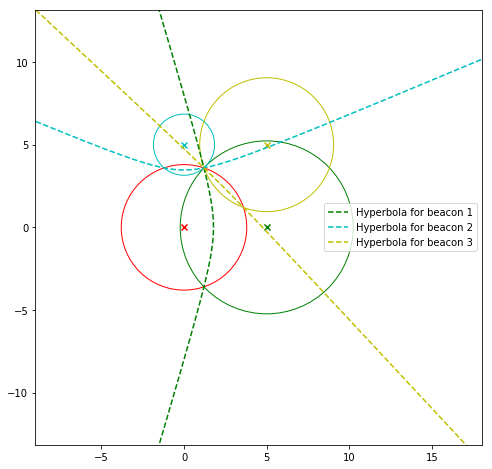

In [3]:
plt.figure(figsize=(8,8))
plot_speakers(plt, coords, distances)
dist=np.multiply(v,TDOA)
colors = ['r', 'g', 'c', 'y', 'm', 'b', 'k']
for i in range(3):
    hyp=draw_hyperbola(coords[i+1], coords[0], dist[i+1]) #Draw hyperbola
    plt.plot(hyp[:,0], hyp[:,1], color=colors[i+1], label='Hyperbola for beacon '+str(i+1), linestyle='--')
plt.xlim(-9, 18)
plt.ylim(-6, 6)
plt.legend()
plt.show()

Solving for the intersection point of these hyperbolic equations in the plot above is computationally simple. However, real recorded signals will have error which will make an exact solution for all the beacons impossible. Least squares can be used to solve for the solution with the minimum amount of error, however this becomes mathematically difficult for non-linear equations such as our hyperbolas. Fortunately, we can linearize our system of equations to make least squares computationally simple and reliable.

**The math that follows assumes we are sacrificing beacon1 to linearize our system. Note that in principle, any beacon other than beacon0 can be sacrificed.** 

**Getting $n-2$ linear equations:** Our hyperbolic solution in the previous section involves a square root we wish to get rid of. Observing that our non-linear term $\sqrt{x^2 + y^2}$ is independent of $x_m$ or $y_m$, we can sacrifice a beacon, $B_1$, to linearize our system:

$$ v_s\tau_m - v_s\tau_1 = \Bigg[\frac{-2x_mx + {x_m}^2 -2y_my + {y_m}^2}{v_s\tau_m} - 2\sqrt{x^2 + y^2}\Bigg] - \Bigg[\frac{-2x_1x + {x_1}^2 -2y_1y + {y_1}^2}{v_s\tau_1} - 2\sqrt{x^2 + y^2}\Bigg]$$

The subtraction removes the non-linear term. The final equation with respect to $B_m$ is ($m$ ranges from 2 to $n-1$): 

$$ \Bigg(\frac{2 x_m}{v_s\tau_m}-\frac{2 x_1}{v_s\tau_1}\Bigg)x + \Bigg(\frac{2 y_m}{v_s\tau_m}-\frac{2 y_1}{v_s\tau_1}\Bigg)y = \Bigg(\frac{{x_m}^2 + {y_m}^2}{v_s\tau_m} - \frac{{x_1}^2 + {y_1}^2}{v_s\tau_1}\Bigg) - \Bigg(v_s\tau_m - v_s\tau_1\Bigg)$$


Below is the same equation written out as a matrix for a system that has $M$ speakers. $x$ and $y$ are the coordinates of your speaker that you would like to solve for.

$$ \large
\begin{bmatrix}
    \frac{2 x_2}{v_s\tau_2}-\frac{2 x_1}{v_s\tau_1} & 
        \frac{2 y_2}{v_s\tau_2}-\frac{2 y_1}{v_s\tau_1} \\
    \frac{2 x_3}{v_s\tau_3}-\frac{2 x_1}{v_s\tau_1} & 
        \frac{2 y_3}{v_s\tau_3}-\frac{2 y_1}{v_s\tau_1} \\
    \vdots & 
        \vdots  \\
    \frac{2 x_m}{v_s\tau_m}-\frac{2 x_1}{v_s\tau_1} & 
        \frac{2 y_m}{v_s\tau_m}-\frac{2 y_1}{v_s\tau_1} \\
    \vdots &
        \vdots \\
    \frac{2 x_M}{v_s\tau_M}-\frac{2 x_1}{v_s\tau_1} & 
        \frac{2 y_M}{v_s\tau_M}-\frac{2 y_1}{v_s\tau_1} \\
\end{bmatrix}
\begin{bmatrix} 
    x \\  
    y 
\end{bmatrix} 
=
\begin{bmatrix} 
    (\frac{{x_2}^2 + {y_2}^2}{v_s\tau_2} - \frac{{x_1}^2 + {y_1}^2}{v_s\tau_1}) - (v_s\tau_2 - v_s\tau_1) \\
    (\frac{{x_3}^2 + {y_3}^2}{v_s\tau_3} - \frac{{x_1}^2 + {y_1}^2}{v_s\tau_1}) - (v_s\tau_3 - v_s\tau_1) \\
    \vdots \\
    (\frac{{x_m}^2 + {y_m}^2}{v_s\tau_m} - \frac{{x_1}^2 + {y_1}^2}{v_s\tau_1}) - (v_s\tau_m - v_s\tau_1) \\
    \vdots \\
    (\frac{{x_M}^2 + {y_M}^2}{v_s\tau_M} - \frac{{x_1}^2 + {y_1}^2}{v_s\tau_1}) - (v_s\tau_M - v_s\tau_1) 
\end{bmatrix}
$$

The result is a linear equation with our position as linear variables.

**<span style="color:red">
What is the minimum number of beacons we need in order to be able to recover a position from our system?
</span>**

YOUR ANSWER HERE: 4

**<span style="color:red">
Why can we not sacrifice `beacon0`?
</span>**

YOUR ANSWER HERE: Because beacon0 is our reference.

Run the code below to plot the speakers of our system.

No handles with labels found to put in legend.


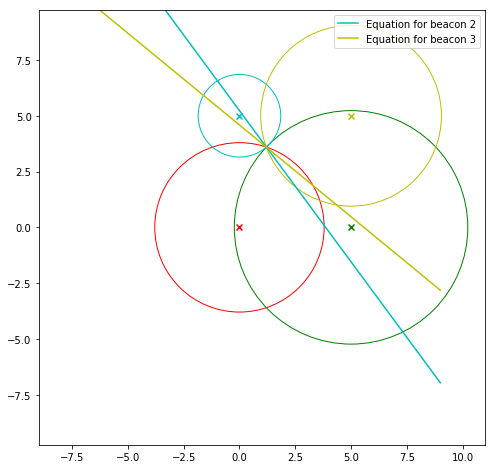

In [5]:
# Plot the speakers
plt.figure(figsize=(8,8))
plot_speakers(plt, coords, distances)

# Plot the linear relationship of the microphone and speakers.
isac=1; #index of the beacon to be sacrificed
TDOA = offsets_to_tdoas(signal_to_offsets(demod), sampling_rate)
helper = lambda i: float(speakers[i][0]**2+speakers[i][1]**2)/(v*TDOA[i])-float(speakers[isac][0]**2+speakers[isac][1]**2)/(v*TDOA[isac])
helperx = lambda i: float(speakers[i][0]*2)/(v*TDOA[i])-float(speakers[isac][0]*2)/(v*TDOA[isac])
helpery = lambda i: float(speakers[i][1]*2)/(v*TDOA[i])-float(speakers[isac][1]*2)/(v*TDOA[isac])

x = np.linspace(-9, 9, 1000)
y1,y2,y3 = [],[],[]
if isac!=1: y1 = [((helper(1)-helper(isac))-v*(TDOA[1]-TDOA[isac])-helperx(1)*xi)/helpery(1) for xi in x]
if isac!=2: y2 = [((helper(2)-helper(isac))-v*(TDOA[2]-TDOA[isac])-helperx(2)*xi)/helpery(2) for xi in x]
if isac!=3: y3 = [((helper(3)-helper(isac))-v*(TDOA[3]-TDOA[isac])-helperx(3)*xi)/helpery(3) for xi in x]

# You can calculate and plot the equations for the other 2 speakers here.
if isac!=1: plt.plot(x, y1, label='Equation for beacon 1', color='g')
if isac!=2: plt.plot(x, y2, label='Equation for beacon 2', color='c')
if isac!=3: plt.plot(x, y3, label='Equation for beacon 3', color='y')
plt.xlim(-9, 11)
plt.ylim(-6, 6)
plt.legend()
plt.show()

As we see in the above example, the microphone's position lies on the intersection of the curves. Finding the position of the microphone is equivalent to finding the solution for the linear system.

**<span style="color:red">
Is our 6 beacon acoustic positioning system in this lab overdetermined or underdetermined? Is this good or bad?
</span>**

YOUR ANSWER HERE: Overdetermined. Good? Because we'll have more validation.

**<span style="color:red">
Compare those two approaches (linear vs. hyperbolic equations). Which approach would be easier to implement?
</span>**

YOUR ANSWER HERE: Linear

Reference (and more reading!): http://en.wikipedia.org/wiki/Multilateration

<a id='task1'></a>
# <span style="color:blue">Task 1: Constructing the System of Equations</span>

Once we find the equations for each speaker and the microphone, we are able to construct a system of linear equations.

**<span style="color:red"> Write the function below that sets up the least squares problem </span>**

For your convenience, the matrix equation is copied here:

$$ \large
\begin{bmatrix}
    \frac{2 x_2}{v_s\tau_2}-\frac{2 x_1}{v_s\tau_1} & 
        \frac{2 y_2}{v_s\tau_2}-\frac{2 y_1}{v_s\tau_1} \\
    \frac{2 x_3}{v_s\tau_3}-\frac{2 x_1}{v_s\tau_1} & 
        \frac{2 y_3}{v_s\tau_3}-\frac{2 y_1}{v_s\tau_1} \\
    \vdots & 
        \vdots  \\
    \frac{2 x_m}{v_s\tau_m}-\frac{2 x_1}{v_s\tau_1} & 
        \frac{2 y_m}{v_s\tau_m}-\frac{2 y_1}{v_s\tau_1} \\
    \vdots &
        \vdots \\
    \frac{2 x_M}{v_s\tau_M}-\frac{2 x_1}{v_s\tau_1} & 
        \frac{2 y_M}{v_s\tau_M}-\frac{2 y_1}{v_s\tau_1} \\
\end{bmatrix}
\begin{bmatrix} 
    x \\  
    y 
\end{bmatrix} 
=
\begin{bmatrix} 
    (\frac{{x_2}^2 + {y_2}^2}{v_s\tau_2} - \frac{{x_1}^2 + {y_1}^2}{v_s\tau_1}) - (v_s\tau_2 - v_s\tau_1) \\
    (\frac{{x_3}^2 + {y_3}^2}{v_s\tau_3} - \frac{{x_1}^2 + {y_1}^2}{v_s\tau_1}) - (v_s\tau_3 - v_s\tau_1) \\
    \vdots \\
    (\frac{{x_m}^2 + {y_m}^2}{v_s\tau_m} - \frac{{x_1}^2 + {y_1}^2}{v_s\tau_1}) - (v_s\tau_m - v_s\tau_1) \\
    \vdots \\
    (\frac{{x_M}^2 + {y_M}^2}{v_s\tau_M} - \frac{{x_1}^2 + {y_1}^2}{v_s\tau_1}) - (v_s\tau_M - v_s\tau_1) 
\end{bmatrix}
$$

In [6]:
v_air = 340.29

def construct_system(speakers, TDOA, isac=1, plot=0):
    """Construct the components of the system according to a list of TDOA's
    Args:
    TDOA (np.array): an array of TDOA's
    isac : index of speaker to be sacrificed for linearization
    
    Returns:
    A (np.matrix): the matrix corresponding to the least squares system
    b (np.array): the vector corresponding to the least squares system
    
    YOUR TASK:
    1. Read over the doc strings to understand how the helper functions are to be implemented
    2. Using the matrix system above as a reference, complete helpers x, y, and b
    3. Take note of x_sac, y_sac, and t_sac below; think about how they can be used in the helper functions
    4. Using your helper functions, complete "BUILDING THE SYSTEM" to make A and b
    """
    x_sac, y_sac = speakers[isac]
    t_sac = TDOA[isac]
    
    def helperx(i):
        """Calculates the value for the ith row in the left column of the A matrix
        Arg:
        i : index of speaker to be used for the calculation
        
        Useful Variables: 
        speakers[i] : returns x_i, y_i (see x_sac and y_sac above for an example)
        TDOA[i] : returns t_i 
        v_air : speed of sound
        
        Returns:
        A[i, 0]'s calculated out value
        """
        # YOUR CODE HERE
        x_m, _ = speakers[i]
        t_m = TDOA[i]
        return 2 * x_m / (v_air * t_m) - 2 * x_sac / (v_air * t_sac)
        
    
    def helpery(i):
        """Calculates the value for the ith row in the right column of the A matrix
        Arg:
        i : index of speaker to be used for the calculation
        
        Useful Variables: 
        speakers[i] : returns x_i, y_i (see x_sac and y_sac above for an example)
        TDOA[i] : returns t_i 
        v_air : speed of sound
        
        Returns:
        A[i, 1]'s calculated out value
        """
        # YOUR CODE HERE
        _, y_m = speakers[i]
        t_m = TDOA[i]
        return 2 * y_m / (v_air * t_m) - 2 * y_sac / (v_air * t_sac)

    
    def helperb(i):
        """Calculates the ith value of the b vector
        Arg:
        i : index of speaker to be used for calculation
        
        Useful Variables: 
        speakers[i] : returns x_i, y_i (see x_sac and y_sac above for an example)
        TDOA[i] : returns t_i 
        v_air : speed of sound
        
        Returns:
        b[i]'s calculated out value
        """
        # YOUR CODE HERE
        x_i, y_i = speakers[i]
        t_i = TDOA[i]
        return (x_i ** 2 + y_i ** 2) / (v_air * t_i) - (x_sac ** 2 + y_sac ** 2) / (v_air * t_sac) - v_air * (t_i - t_sac)

    
    # BUILDING THE SYSTEM
    A, b = [], []
    for i in range(1, len(TDOA)):
        if (i!=isac): #if i is not the index of the beacon to be sacrificed, add elements to A and b
            # YOUR CODE HERE
            A_x = helperx(i)
            A_y = helpery(i)

            A.append([A_x, A_y])
            b.append(helperb(i))

            
            
    # PLOTTING
    if plot==1: #plot the linear equations
        x = np.linspace(-9, 9, 1000)
        for i in range(len(b)):
            y = [(b[i] - A[i][0]*xi) / A[i][1] for xi in x]
            plt.plot(x, y, label="Equation" + str(i + 1))   
        plt.xlim(-9, 9)
        plt.ylim(-6, 6)
        plt.legend()
        plt.show()
        
    # NORMALIZATIONS
    AA, bb = [], []
    for i in range(len(A)):
        AA.append([A[i][0]/np.linalg.norm(A[i]), A[i][1]/np.linalg.norm(A[i])])
        bb.append(b[i]/np.linalg.norm(A[i]))  
        
    return np.array(AA), np.array(bb)

Take a look at your results and make sure it works correctly (Don't worry if there are some small errors on order of +/- 0.5):

In [7]:
A, b = construct_system(speakers,TDOA)

for i in range(len(b)):
    print ("Row %d: %.f should equal %.f"%(i, A[i][0] * 1.2 + A[i][1] * 3.6, b[i]))

Row 0: -3 should equal -3
Row 1: 4 should equal 4
Row 2: -2 should equal -2
Row 3: 1 should equal 1


$$ \large
\begin{bmatrix}
    \frac{2 x_2}{v_s\tau_2}-\frac{2 x_1}{v_s\tau_1} & 
        \frac{2 y_2}{v_s\tau_2}-\frac{2 y_1}{v_s\tau_1} \\
    \frac{2 x_3}{v_s\tau_3}-\frac{2 x_1}{v_s\tau_1} & 
        \frac{2 y_3}{v_s\tau_3}-\frac{2 y_1}{v_s\tau_1} \\
    \vdots & 
        \vdots  \\
    \frac{2 x_m}{v_s\tau_m}-\frac{2 x_1}{v_s\tau_1} & 
        \frac{2 y_m}{v_s\tau_m}-\frac{2 y_1}{v_s\tau_1} \\
    \vdots &
        \vdots \\
    \frac{2 x_M}{v_s\tau_M}-\frac{2 x_1}{v_s\tau_1} & 
        \frac{2 y_M}{v_s\tau_M}-\frac{2 y_1}{v_s\tau_1} \\
\end{bmatrix}
\begin{bmatrix} 
    x \\  
    y 
\end{bmatrix} 
=
\begin{bmatrix} 
    (\frac{{x_2}^2 + {y_2}^2}{v_s\tau_2} - \frac{{x_1}^2 + {y_1}^2}{v_s\tau_1}) - (v_s\tau_2 - v_s\tau_1) \\
    (\frac{{x_3}^2 + {y_3}^2}{v_s\tau_3} - \frac{{x_1}^2 + {y_1}^2}{v_s\tau_1}) - (v_s\tau_3 - v_s\tau_1) \\
    \vdots \\
    (\frac{{x_m}^2 + {y_m}^2}{v_s\tau_m} - \frac{{x_1}^2 + {y_1}^2}{v_s\tau_1}) - (v_s\tau_m - v_s\tau_1) \\
    \vdots \\
    (\frac{{x_M}^2 + {y_M}^2}{v_s\tau_M} - \frac{{x_1}^2 + {y_1}^2}{v_s\tau_1}) - (v_s\tau_M - v_s\tau_1) 
\end{bmatrix}
$$

Looking at the matrix form of our system, comment on the following:

**<span style="color:red">
Why does the first row of the matrix start at $m=2$? Why does it not make sense to start at $m=0$ or $1$?
</span>**

**YOUR ANSWER HERE:** 
0 is our reference, and 1 is our sacrifice

**<span style="color:red">
What is the minimum number of rows that the matrix requires for this system to be solvable? Understanding how Linear Least Squares works, do we want more or exactly that many rows to get an accurate reading of our position?
</span>**

**YOUR ANSWER HERE**:  
min: 2.
More

<a id='task2'></a>
# <span style="color:blue">Task 2: Using Least Squares</span>

**Definition**: If $A$ is an $m \times n$ matrix and $\vec{b}$ is in $\mathbb{R}^m$, a **least-squares solution** of $A\vec{x}=\vec{b}$ is an $\hat{\vec{x}}$ in $\mathbb{R}^n$ such that for all $\vec{x}$ in $\mathbb{R}^n$: $||\vec{b} - A\hat{\vec{x}}|| \leq ||\vec{b} - A\vec{x}||$.

The solution for an overdetermined problem is given by solving the normal equations: $A^TA\vec{x}=A^T\vec{b}$.

**Why do we need least-squares here?**

During the transmission of sound in air, some noise is added into the signal. Most of the time we don't receive the original signal perfectly; in other words, the linear system is no longer consistent due to the modified signal. Also in our positioning system, we have more than 2 linear equations to improve the accuracy. However with more equations, the linear system is more likely to be inconsistent. Least-squares solution ensures a best approximation we can get, even if there is technically no solution to the system.

**<span style="color:red">Implement the following function given arguments matrix A and vector b. Implement your own function of solving least-squares, do not use the least squares solver built into python.</span>**

In [13]:
def least_squares(A, b):
    """Solve the least squares problem
    
    Args:
    A (np.array): the matrix in the least squares problem
    b (np.array): the vector in the least squares problem
    
    Returns:
    pos (np.array): the result of the least squares problem (x)    
    """

    # BEGIN SOLUTION
    # YOUR CODE HERE
    A_t = np.transpose(A)
    step1 = np.dot(A_t, A)
    inverse = np.linalg.inv(step1)
    return np.dot(np.dot(inverse, A_t), b)
    # END SOLUTION

**<span style="color:red">Test your least squares function for a simple case in the cell below.</span>**

In [14]:
A = np.array(((1,1),(1,2),(1,3),(1,4)))
b = np.array((6, 5, 7, 10))
yourres = least_squares(A,b)
print('Your results: ',yourres)
correctres = np.linalg.lstsq(np.array(A), np.array(b))[0]
print('Correct results: ',correctres)

Your results:  [3.5 1.4]
Correct results:  [3.5 1.4]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """


**<span style="color:red">Run the next following blocks to make sure your least squares estimate works for our positioning system (Don't worry about small errors).</span>**

In [15]:
# Define a dictionary to allow us to switch between the 
get_signal = {'virtual': get_signal_virtual} #, 'actual': get_signal_actual}

# Define a helper function to use least squares to calculate position from just the TDOAs
def calculate_position(speakers, TDOA, isac=1):
    return least_squares(*construct_system(speakers, TDOA, isac))

# Define a testing function
def test_loc(x_pos, y_pos, inten, src, debug=False):
    raw_signal = get_signal[src](mode="Location", x=x_pos, y=y_pos, intensity=inten)
    
    # Demodulate raw signal
    demod = demodulate_signal(raw_signal)
    
    # Separate the beacon signals
    separated = separate_signal(demod)

    # Perform our averaging function
    avg = average_sigs(separated)

    # Calculate offsets and TDOAs
    offsets = identify_offsets(avg)
    TDOA = offsets_to_tdoas(signal_to_offsets(demod), sampling_rate)

    # Construct system of equations
    A, b = construct_system(speakers, TDOA)

    # Calculate least squares solution
    pos = calculate_position(speakers, TDOA)

    if debug:
        # Plot the averaged output for each beacon
        plt.figure(figsize=(12,6))
        for i in range(len(avg)):
            plt.subplot(3,2,i+1)
            plt.plot(avg[i])
            plt.title("Beacon %d"%i)
        plt.tight_layout()

        # Plot the averaged output for each beacon centered about beacon0
        plt.figure(figsize=(16,4))
        peak = identify_peak(avg[0])
        for i in range(len(avg)):
            plt.plot(np.roll(avg[i], len(avg[0]) // 2 - peak), label="{0}".format(i))
        plt.title("Beacons Detected")
        plt.legend()
        plt.show()

        print( "Offsets (samples): %s"%str(offsets))
        print( "Times (s): [%s]\n"%", ".join(["%0.6f" % t for t in TDOA]))
        print( "Constructing system...")
        print( "Verifying system using known position...")
        for i in range(len(b)):
            print( "Row %d: %.f should equal %.f"%(i, A[i][0] * x_pos + A[i][1] * y_pos, b[i]))

        print( "\nCalculating least squares estimate...")
    print("Expected: (%.3f, %.3f); got (%.3f, %.3f)\n"%(x_pos, y_pos, pos[0], pos[1]))

**<span style="color:red">Test your code with noisy inputs. Are all of the estimates in the cases with noise reasonable? Why or why not?</span>**
(Don't worry if there are some small errors on the order of +/- 0.1)

In [16]:
# Testing signals with noise
test_loc(1.2, 3.6, 30, 'virtual')
test_loc(1.2, 3.6, 40, 'virtual')
test_loc(1.2, 3.6, 50, 'virtual')

Expected: (1.200, 3.600); got (1.204, 3.597)

Expected: (1.200, 3.600); got (1.204, 3.598)

Expected: (1.200, 3.600); got (1.195, 3.604)



<a id='task3a'></a>
# <span style="color:blue">Task 3a: Simulation Testing</span>

### You will go through a simulation to ensure that your code is working for a stable, slightly noisy simulation.

In [17]:
# Adata.mat contains beacon signals

mat_file = scipy.io.loadmat('support_code/Adata.mat')
beacons = [mat_file["beacon0"][0],  
           mat_file["beacon1"][0], 
           mat_file["beacon2"][0],
           mat_file["beacon3"][0],
           mat_file["beacon4"][0],
           mat_file["beacon5"][0]]

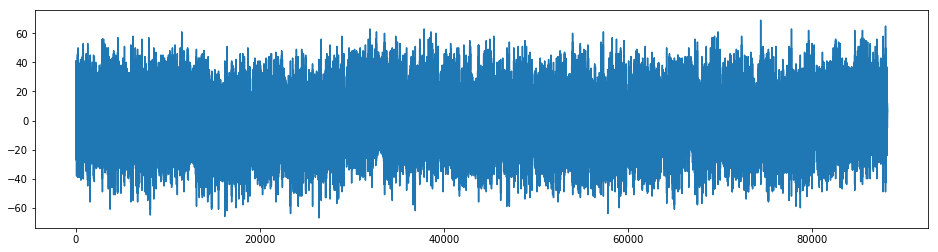

In [18]:
raw_signal = np.load('raw_signal_beacon45.npy') #Load in simulation data

plt.figure(figsize=(16,4))
plt.plot(raw_signal)

**<span style="color:red">Make sure you see well defined peaks. This is still a simulation so you should see a distinct peak in each plot.</span>**

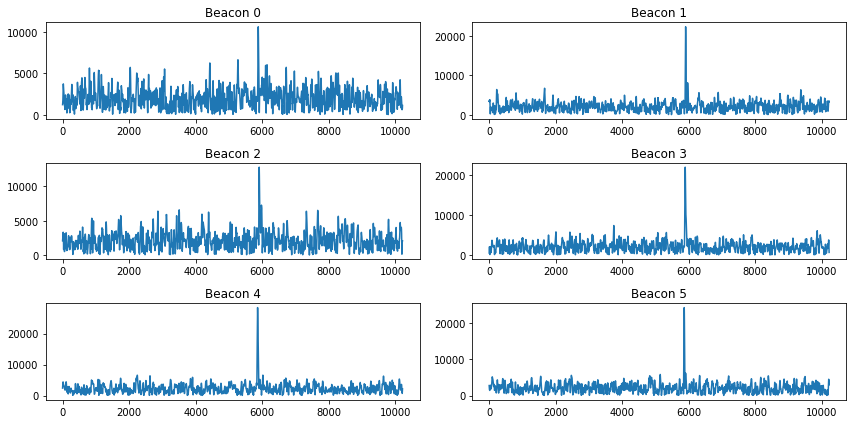

In [19]:
# Demodulate raw signal
demod = demodulate_signal(raw_signal)
    
# Separate the beacon signals
separated = separate_signal(demod)

# Perform our averaging function
avg = average_sigs(separated)

# Plot the averaged output for each beacon
fig = plt.figure(figsize=(12,6))
for i in range(len(avg)):
    plt.subplot(3,2,i+1)
    plt.plot(avg[i])
    plt.title("Beacon %d"%i)
plt.tight_layout()

Run the code below to plot hyperbolas associated with the peaks. The simulation's hyperbola should show an intersection closer to beacons 4 and 5

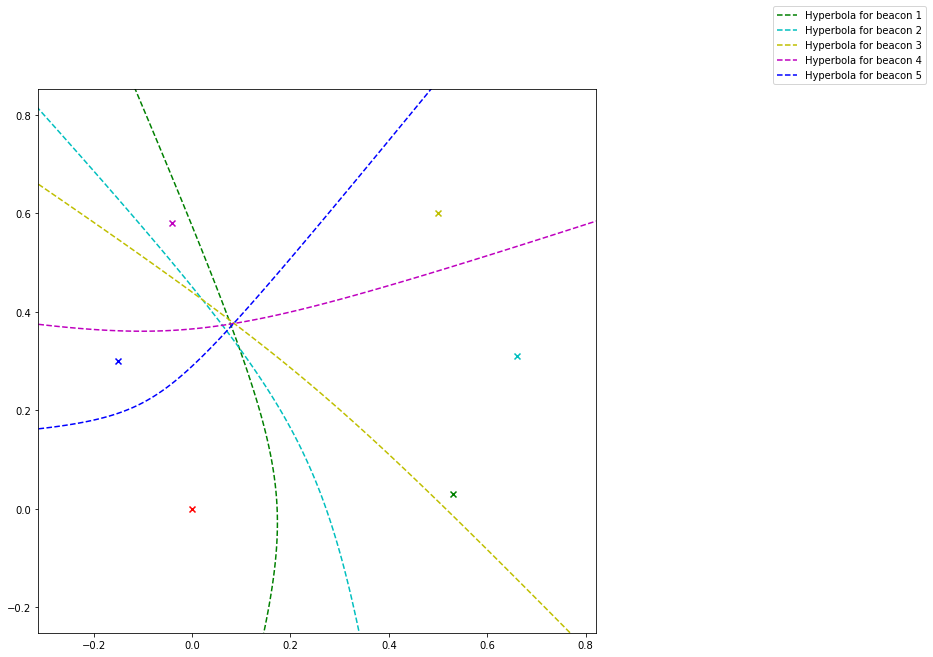

In [20]:
# Load Beaker Locations for Simulation
simulation = np.array([(0.,0.),(0.53,0.03),(0.66,0.31),(0.50,0.6),(-0.04,0.58),(-0.15,0.30)])

# Calculate distances and plot
distances = signal_to_distances(demod, 0)
plt.figure(figsize=(10,10))

colors = ['r', 'g', 'c', 'y', 'm', 'b', 'k']
for i in range(5):
    hyp=draw_hyperbola(simulation[i+1], simulation[0], distances[i+1]) #Draw hyperbola
    plt.plot(hyp[:,0], hyp[:,1], color=colors[i+1], label='Hyperbola for beacon '+str(i+1), linestyle='--')
plot_speakers(plt, simulation, distances, circle=False)

xmin = min(simulation[:,0])
xmax = max(simulation[:,0])
xrange = xmax-xmin
ymin = min(simulation[:,1])
ymax = max(simulation[:,1])
yrange = ymax-ymin

plt.xlim(xmin-xrange*.2, xmax+xrange*.2)
plt.ylim(ymin-yrange*.2, ymax+yrange*.2)
plt.legend(bbox_to_anchor=(1.6, 1))
plt.show()

**<span style="color:red">Run the code below to linearize the system.</span>**

Distance differences (m)): [0.0000, 0.1852, 0.2238, 0.0849, -0.1466, -0.1389]

Least Squares Position: 0.1502, 0.3308
Actual Simulation Microphone Position: (0.15, 0.33)
Distances from Speakers : [0.3633, 0.5485, 0.5871, 0.4482, 0.2167, 0.2244]



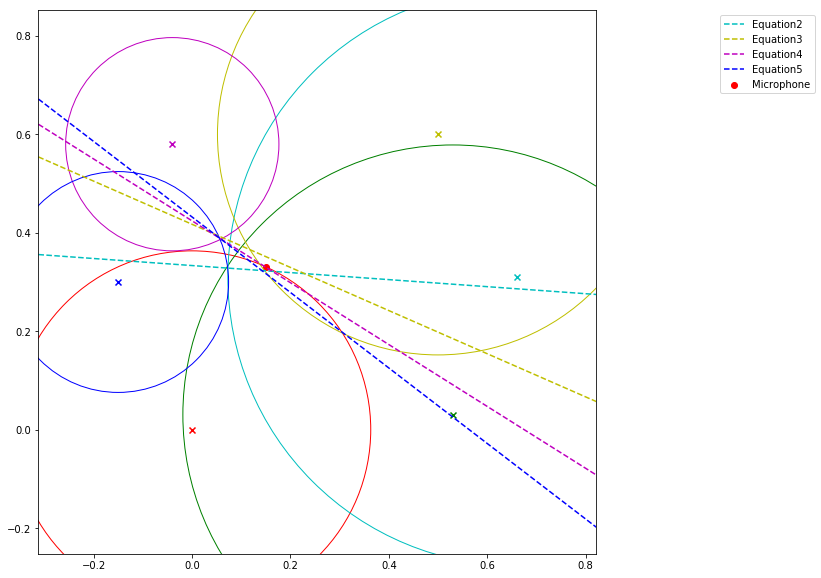

In [21]:
isac=1 #index of speaker to be sacrificed

# Calculate quantities and compute least squares solution
offsets = signal_to_offsets(demod)

distances = signal_to_distances(demod, 0)
TDOA = offsets_to_tdoas(offsets, sampling_rate)
x, y = calculate_position(simulation, TDOA, isac)

print( "Distance differences (m)): [%s]\n"%", ".join(["%0.4f" % d for d in distances]))
print( "Least Squares Position: %0.4f, %0.4f" % (x, y))
print( "Actual Simulation Microphone Position: (0.15, 0.33)")

# Find distance from speaker 0 for plotting
dist_from_origin = np.linalg.norm([x, y])
dist_from_speakers = [d + dist_from_origin for d in distances]
print( "Distances from Speakers : [%s]\n"%", ".join(["%0.4f" % d for d in dist_from_speakers]))

# Plot speakers
plt.figure(figsize=(10,10))
plt.scatter(x, y, marker='o', color='r', label='Microphone')
plot_speakers(plt, simulation, [d for d in dist_from_speakers])
xmin = min(simulation[:,0])
xmax = max(simulation[:,0])
xrange = xmax-xmin
ymin = min(simulation[:,1])
ymax = max(simulation[:,1])
yrange = ymax-ymin


# For debugging; plot linear equations for LS
A, b = construct_system(simulation, TDOA, isac) #for debugging
colors = ['r', 'g', 'c', 'y', 'm', 'b', 'k']
x2 = np.linspace(xmin-xrange*.2, xmax+xrange*.2, 1000)
j=0;

for i in range(len(b)):
    if i==isac-1: j=j+2
    else: j=j+1
    y2 = [(b[i] - A[i][0]*xi) / A[i][1] for xi in x2]
    plt.plot(x2, y2, color=colors[j], label="Equation" + str(j), linestyle='--')
    plt.xlim(xmin-xrange*.2, xmax+xrange*.2)
    plt.ylim(ymin-yrange*.2, ymax+yrange*.2)
    plt.legend(bbox_to_anchor=(1.4, 1))
    

<a id='task3b'></a>
# <span style="color:blue">Task 3b: Real Life Positioning</span>

**Now we will use real life data and try to use our code to locate the microphone! We will supply you with a recording for a microphone placed in one of 5 locations: the middle of each quadrant or the dead center of the recording setup. It is up to you and your code to determine where we took the recording. **

You can ignore the `YOUR SIGNAL HERE` for now - you will use it in Task 3c if you would like.

/anaconda3/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


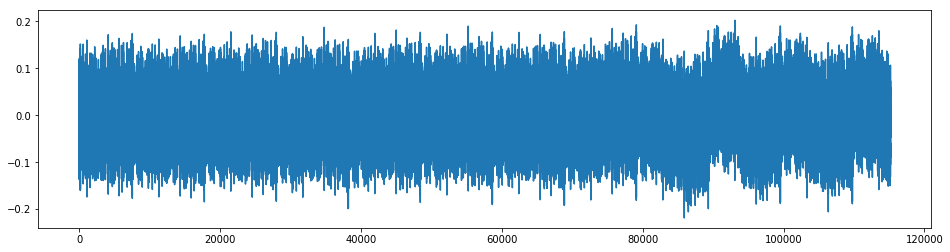

In [22]:
# Load your recorded wave file
import scipy.io.wavfile
record_rate, raw_signal = scipy.io.wavfile.read('mystery_signal.wav')
# record_rate, raw_signal = scipy.io.wavfile.read('YOUR SIGNAL HERE.wav')

# Get single channel
raw_signal = raw_signal[:,0]

plt.figure(figsize=(16,4))
plt.plot(raw_signal)

Argmax of beacon  0 :  9662
Argmax of beacon  1 :  9640
Argmax of beacon  2 :  9616
Argmax of beacon  3 :  9611
Argmax of beacon  4 :  9642
Argmax of beacon  5 :  9655


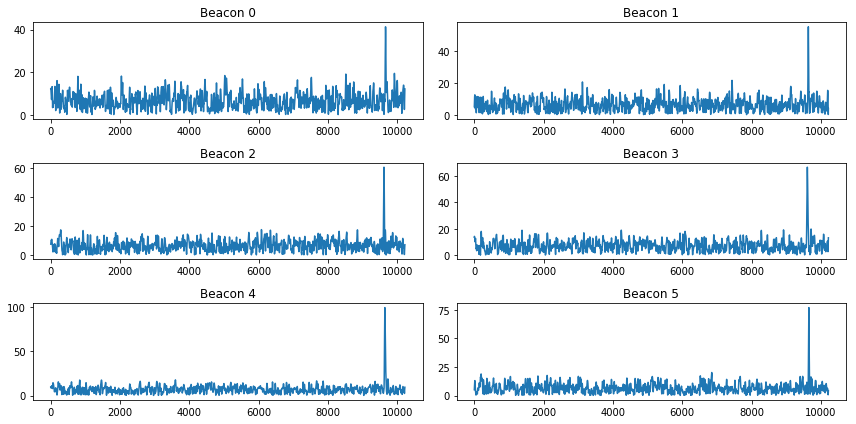

In [23]:
# Demodulate raw signal
demod = demodulate_signal(raw_signal)
    
# Separate the beacon signals
separated = separate_signal(demod)

# Perform our averaging function
avg = average_sigs(separated)

# Plot the averaged output for each beacon
fig = plt.figure(figsize=(12,6))
for i in range(len(avg)):
    plt.subplot(3,2,i+1)
    plt.plot(avg[i])
    plt.title("Beacon %d"%i)
    print("Argmax of beacon ", i, ": ", np.argmax(avg[i]))
plt.tight_layout()

**<span style="color:red">Make sure you see a well defined peak in the correlations in the 6 plots.</span>**

**Run the block below to set the location of the speakers.**

In [24]:
# Locations of speakers for built-in recordings. DO NOT MODIFY
speakers = np.array([(0,0),(0.53,0.03),(0.66,0.31),(0.50,0.60),(-0.04,0.58), (-0.15,0.30)])

Run the code below to plot hyperbolas associated with the peaks. **Could you guess the position of the microphone from the hyperbolic plots?**

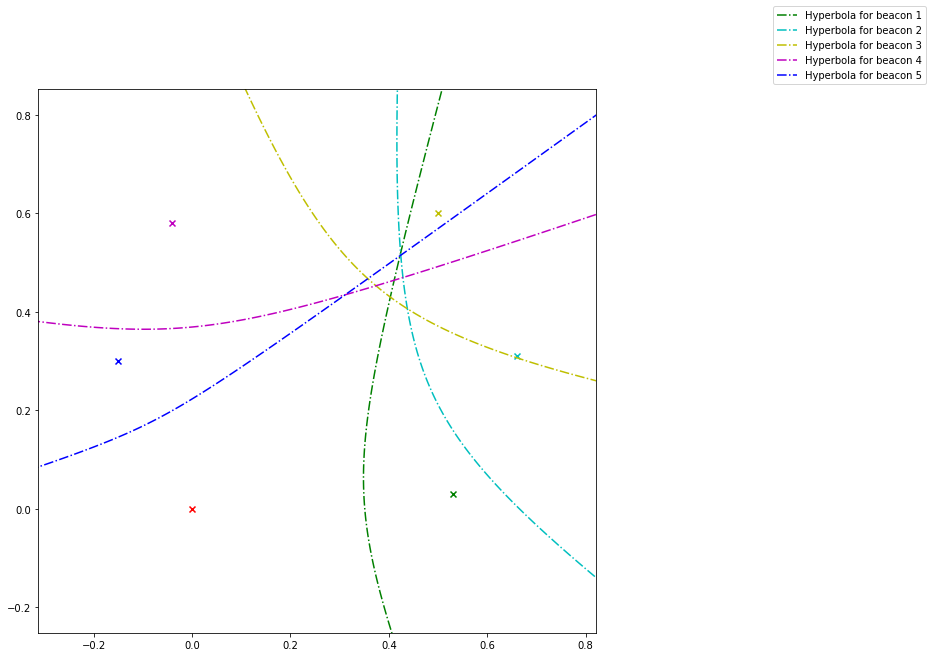

In [25]:
# Plot Hyperbolas
distances = signal_to_distances(demod, 0)
plt.figure(figsize=(10,10))

colors = ['r', 'g', 'c', 'y', 'm', 'b', 'k']
for i in range(5):
    hyp=draw_hyperbola(speakers[i+1], speakers[0], distances[i+1]) #Draw hyperbola
    plt.plot(hyp[:,0], hyp[:,1], color=colors[i+1], label='Hyperbola for beacon '+str(i+1), linestyle='-.')
plot_speakers(plt, speakers, distances, circle=False)

xmin = min(speakers[:,0])
xmax = max(speakers[:,0])
xrange = xmax-xmin
ymin = min(speakers[:,1])
ymax = max(speakers[:,1])
yrange = ymax-ymin

plt.xlim(xmin-xrange*.2, xmax+xrange*.2)
plt.ylim(ymin-yrange*.2, ymax+yrange*.2)
plt.legend(bbox_to_anchor=(1.6, 1))
plt.show()


**<span style="color:red">Run the code below to determine the position of the microphone using linearization and linear least squares</span>** 

Tip for bad linear approximation: Set the ISAC (the index of the sacrificed beacon) to be a really good non-zero peak from the separated beacons. We have already sacrificed beacon0 before so we cannot sacrifice it again.

Distance differences (m)): [0.0000, -0.1698, -0.3550, -0.3935, -0.1543, -0.0540]

Least Squares Position: 0.4025, 0.4641
Distances from Speakers : [0.6143, 0.4445, 0.2593, 0.2208, 0.4600, 0.5603]



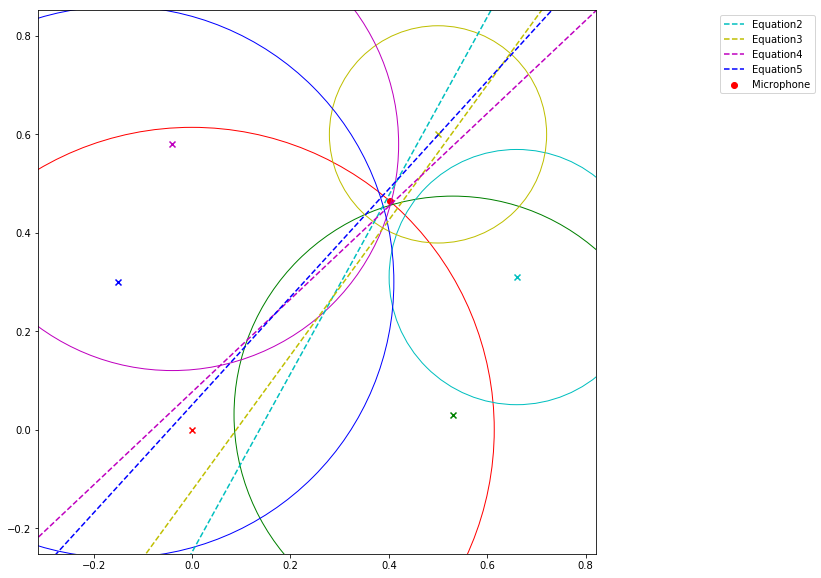

In [26]:
isac = 1 # index of speaker to be sacrificed. Choose a good non-zero peak beacon to sacrifice

# Calculate quantities and compute least squares solution
offsets = signal_to_offsets(demod)

distances = signal_to_distances(demod, 0)
TDOA = offsets_to_tdoas(offsets, sampling_rate)
x, y = calculate_position(speakers, TDOA, isac)

print( "Distance differences (m)): [%s]\n"%", ".join(["%0.4f" % d for d in distances]))
print( "Least Squares Position: %0.4f, %0.4f" % (x, y))

# Find distance from speaker 0 for plotting
dist_from_origin = np.linalg.norm([x, y])
dist_from_speakers = [d + dist_from_origin for d in distances]
print( "Distances from Speakers : [%s]\n"%", ".join(["%0.4f" % d for d in dist_from_speakers]))

A, b = construct_system(speakers, TDOA, isac)
colors = ['r', 'g', 'c', 'y', 'm', 'b', 'k']
x2 = np.linspace(xmin-xrange*.2, xmax+xrange*.2, 1000)
j=0;

plt.figure(figsize=(10,10))

plt.scatter(x, y, marker='o', color='r', label='Microphone')
plot_speakers(plt, speakers, [d for d in dist_from_speakers])

for i in range(len(b)):
    if i==isac-1: j=j+2
    else: j=j+1
    y2 = [(b[i] - A[i][0]*xi) / A[i][1] for xi in x2]
    plt.plot(x2, y2, color=colors[j], label="Equation" + str(j), linestyle='--')
plt.xlim(xmin-xrange*.2, xmax+xrange*.2)
plt.ylim(ymin-yrange*.2, ymax+yrange*.2)
plt.legend(bbox_to_anchor=(1.4, 1))

## **Congratulations!**
You have successfully located a mic using techniques learned in lecture

<a id='task3c'></a>
# <span style="color:blue">Task 3c (Optional): Getting your own recording</span>

If you would like to obtain your own recording and see if you can locate the mic, please head over to Cory 140 (if you are already not there) and ask the TA to assist you in taking a recording. You can email it to yourself, download it, and place it in the same folder as the notebook to load. Find the block that has `YOUR SIGNAL HERE`. Uncomment it and replace `YOUR SIGNAL HERE` with the name of the `.wav` file you recorded and loaded in. Run all the subsequent blocks of code and see if the notebook was able to locate where you placed the microphone! 

*Note:* There are many nonidealities present in our system that may cause it to not work - the speakers are very close to each other, so there may not be a necessary offset from beacon0 when taking cross correlations, resulting in a divide by 0 error. Depending on the placement of the microphone, a beacon might be flooded out and not found within the signal.

<a id='checkoff'></a>
## Checkoff
When you are ready to get checked off, please have each person in your group fill out the [Check Off Form](https://goo.gl/forms/nyH0n2enRvmNWnIo2). Follow the form exactly and submit. Your GSI or a Lab Assistant will come by once they are available and go through some checkoff questions with your group. Do not take apart your setup before being checked off.